In [1]:
import numpy as np
import torch
from torch.nn.functional import relu

from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import pennylane as qml
from pennylane.templates import AngleEmbedding, StronglyEntanglingLayers
from pennylane.operation import Tensor

import matplotlib.pyplot as plt
import tensorflow as tf

np.random.seed(42)

In [2]:
imsize = 16
(train_images, train_labels),(test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images = np.expand_dims(train_images, axis=-1)
train_images_resize = tf.image.resize(train_images, [imsize,imsize]).numpy()
train_images_resize = train_images_resize.reshape(60000, imsize**2)
train_images_resize = train_images_resize/255
mnist_dataset = normalize(train_images_resize[:10000])
train_labels = train_labels[:10000]

2022-02-10 14:44:53.322406: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW


In [3]:
# PCA on the dataset k > 2 
k=3
pca = PCA(n_components=k)

print("Fitting Data....")
pca.fit(mnist_dataset)
print("Variance Ratio = ", pca.explained_variance_ratio_)
print("Variance Ratio Cumulative = ", sum(pca.explained_variance_ratio_))
X = pca.transform(mnist_dataset)

Fitting Data....
Variance Ratio =  [0.10994853 0.07978019 0.06644788]
Variance Ratio Cumulative =  0.2561765983700752


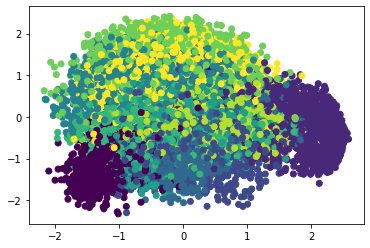

In [4]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
plt.scatter(X[:,0], X[:,1],c=train_labels)
plt.show()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, train_labels)

In [6]:
n_qubits = len(X_train[0])
n_qubits

3

In [7]:
dev_kernel = qml.device("default.qubit", wires=n_qubits)

projector = np.zeros((2**n_qubits, 2**n_qubits))
projector[0, 0] = 1

@qml.qnode(dev_kernel)
def kernel(x1, x2):
    """The quantum kernel."""
    AngleEmbedding(x1, wires=range(n_qubits))
    qml.adjoint(AngleEmbedding)(x2, wires=range(n_qubits))
    return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))

In [8]:
kernel(X_train[0], X_train[0])

tensor(1., requires_grad=True)

In [9]:
def kernel_matrix(A, B):
    """Compute the matrix whose entries are the kernel
       evaluated on pairwise data from sets A and B."""
    return np.array([[kernel(a, b) for b in B] for a in A])

In [10]:
svm = SVC(kernel=kernel_matrix).fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
predictions = svm.predict(X_test)
print(predictions)
accuracy_score(predictions, y_test)